# volmc demo

In [1]:
from volmc import Path, State, SimulationResult, LocalVolatilitySurface
from volmc import Heston, BlackScholes, Dupire
from volmc import EulerHeston, EulerBlackScholes, QE, EulerDupire
from volmc import MonteCarlo

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

## Black-Scholes

In [2]:
bs = BlackScholes(mu = 0.02, sigma = 0.15)
montecarlo = MonteCarlo(EulerBlackScholes(bs))
montecarlo.configure(seed=1, n_jobs=-1) #-1 uses all core available

In [3]:
sim = montecarlo.generate(S0 = 100, n = 252, T = 1, n_paths= 100_000)

In [4]:
sim

SimulationResult of 100000 paths and 253 steps

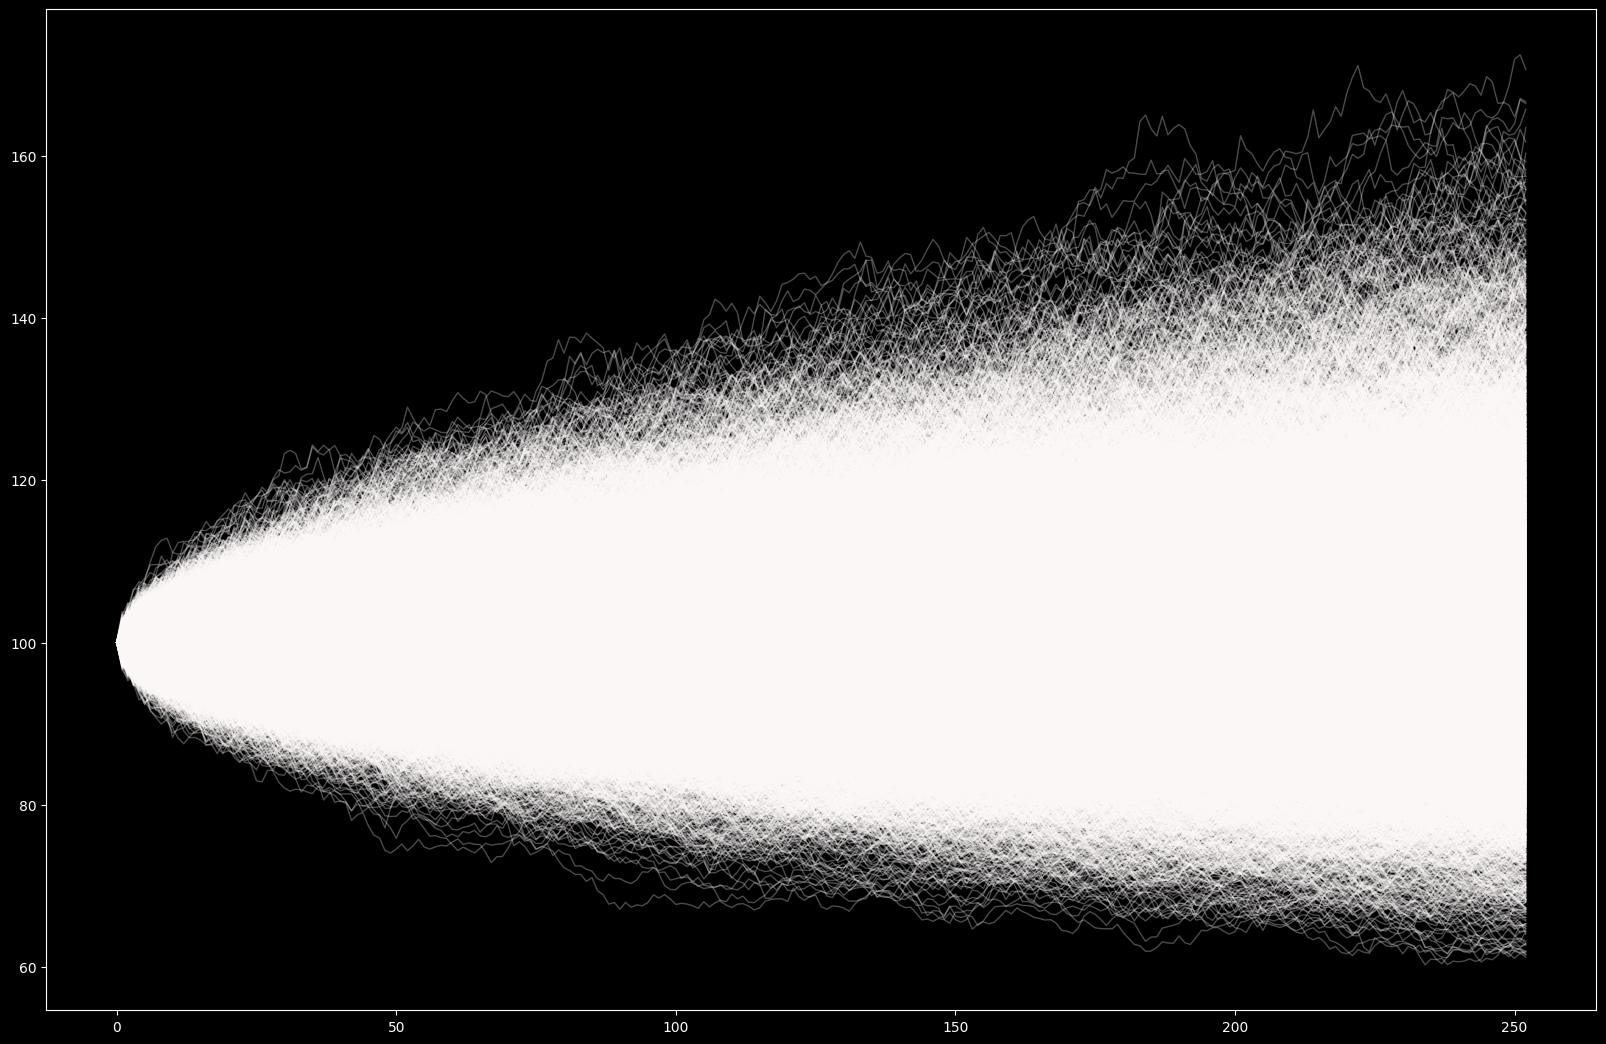

In [5]:
S = sim.spot_values()

%matplotlib inline
plt.style.use("dark_background")
plt.figure(figsize=(20,13))

for s in S[::10]: 
    plt.plot(s, color="snow", lw=1, alpha=0.3)
plt.show()

## Heston

In [6]:
heston = Heston(mu=0.02, 
                kappa=2, 
                theta= 0.05, 
                epsilon=0.3, 
                rho = -0.6)

print(f"Feller condition met : {heston.feller_condition()}")

Feller condition met : True


In [7]:
mc = MonteCarlo(
    EulerHeston(heston))
mc.configure(seed=1, n_jobs = -1)

In [8]:
sim = mc.generate(S0=100, n=252, T=1, n_paths=100_000, v0=0.04)

In [9]:
S = sim.spot_values()
V = sim.var_values()

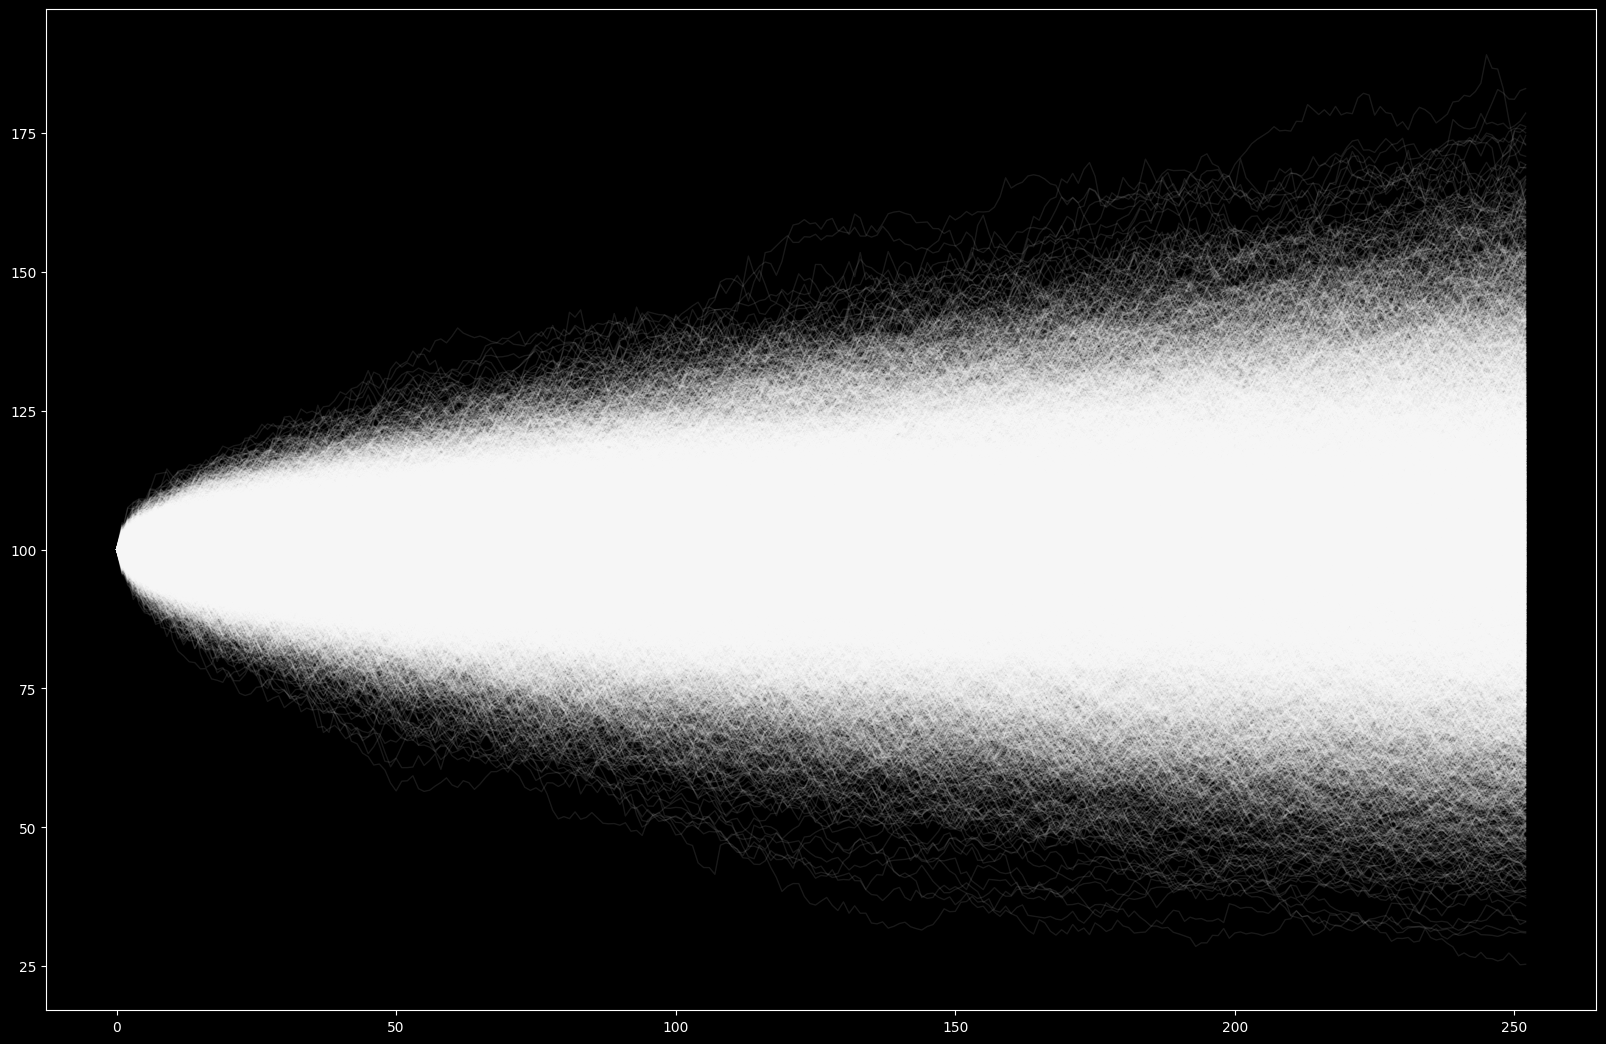

In [10]:
plt.figure(figsize=(20,13))

for s in S[::10]:
    plt.plot(s, color = "white", lw = 1, alpha= 0.1)
plt.show()

In [11]:
np.mean((S[:, -1]))

101.99377

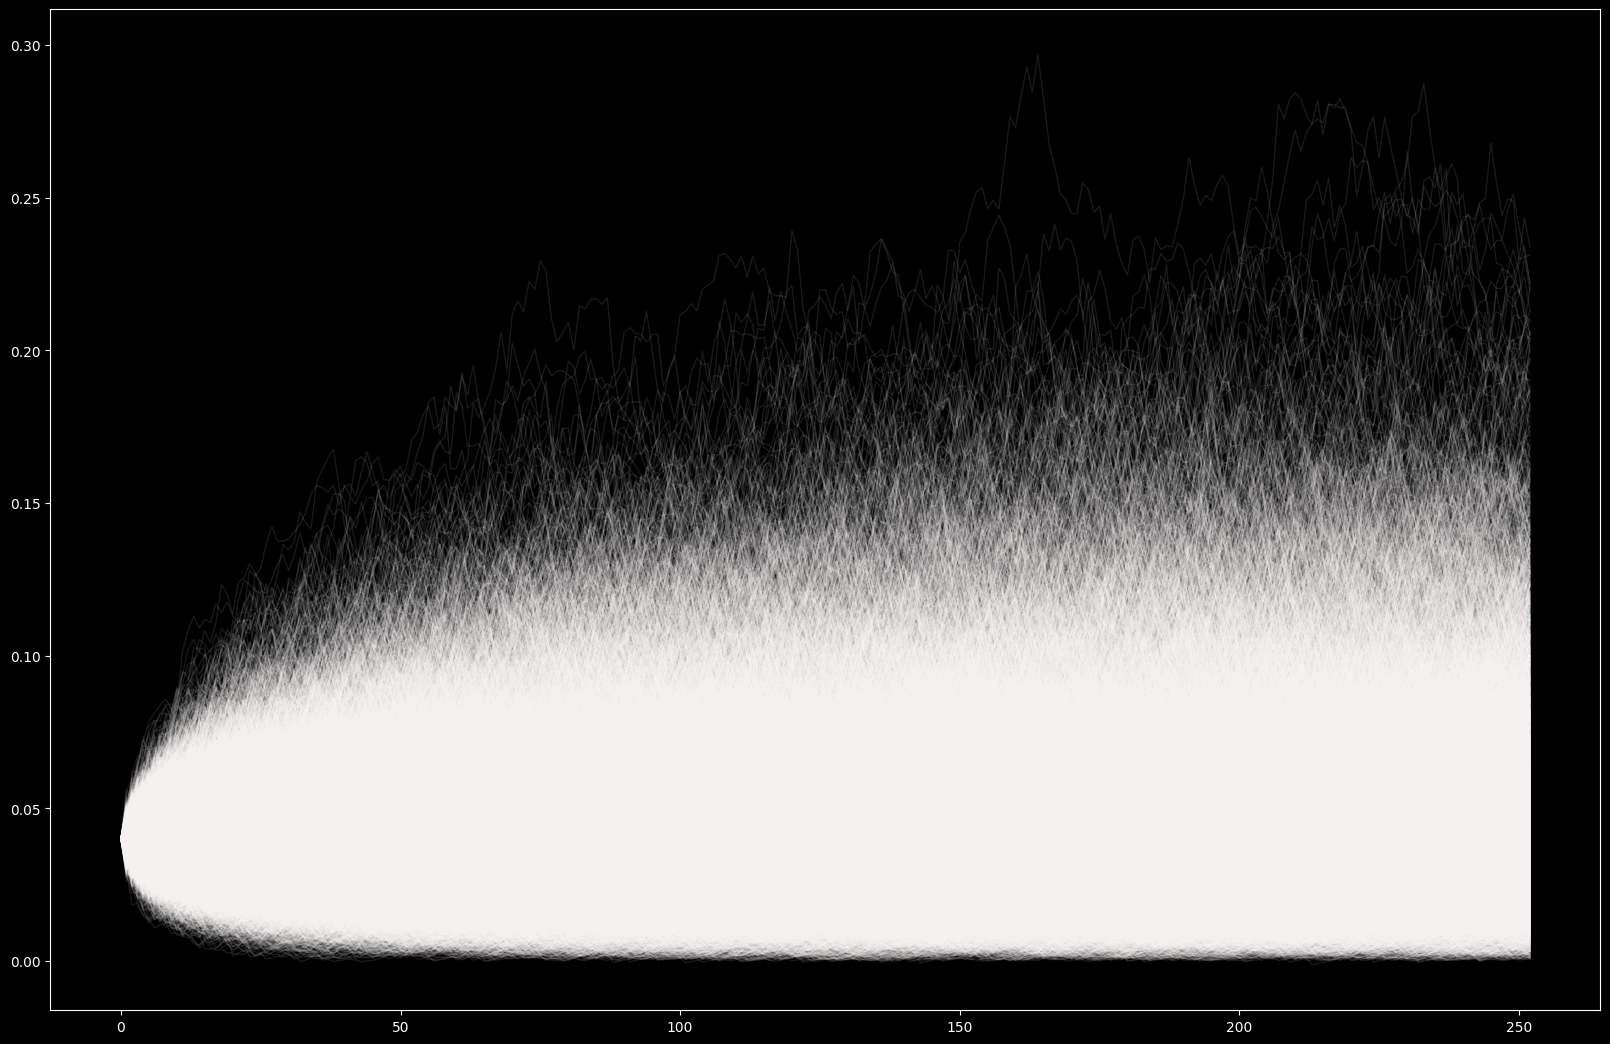

In [12]:
plt.figure(figsize=(20,13))

for v in V[::10]:
    plt.plot(v, lw = 1, alpha= 0.1, color = "snow")
plt.show()

In [13]:
heston = Heston(mu=0.02, 
                kappa=2, 
                theta= 0.05, 
                epsilon=0.3, 
                rho = -0.6)

print(f"Feller condition met : {heston.feller_condition()}")

Feller condition met : True


In [14]:
mc = MonteCarlo(
    QE(heston))
mc.configure(seed=1)

sim = mc.generate(S0 = 100, v0 = 0.04, n = 252, T = 1, n_paths = 100_000)

S = sim.spot_values()
V = sim.var_values()

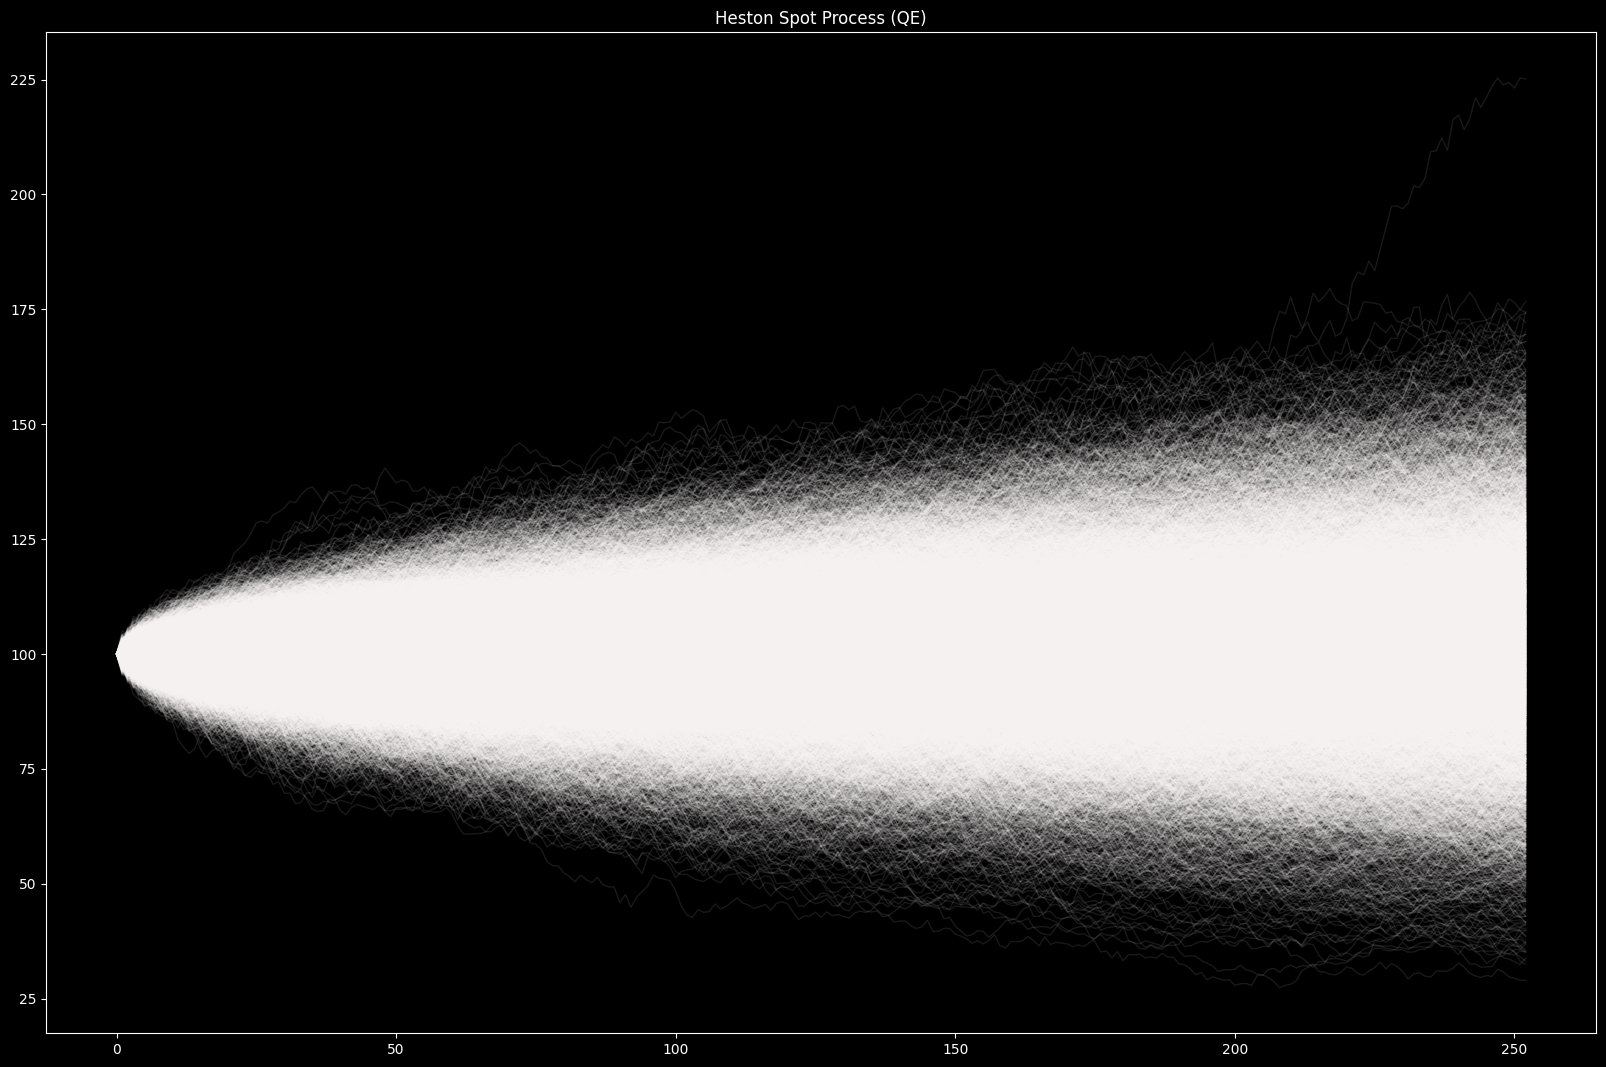

In [15]:
plt.figure(figsize=(20,13))

for s in S[::10]:
    plt.plot(s, color = "snow", lw = 1, alpha= 0.1)
plt.title("Heston Spot Process (QE)")
plt.show()

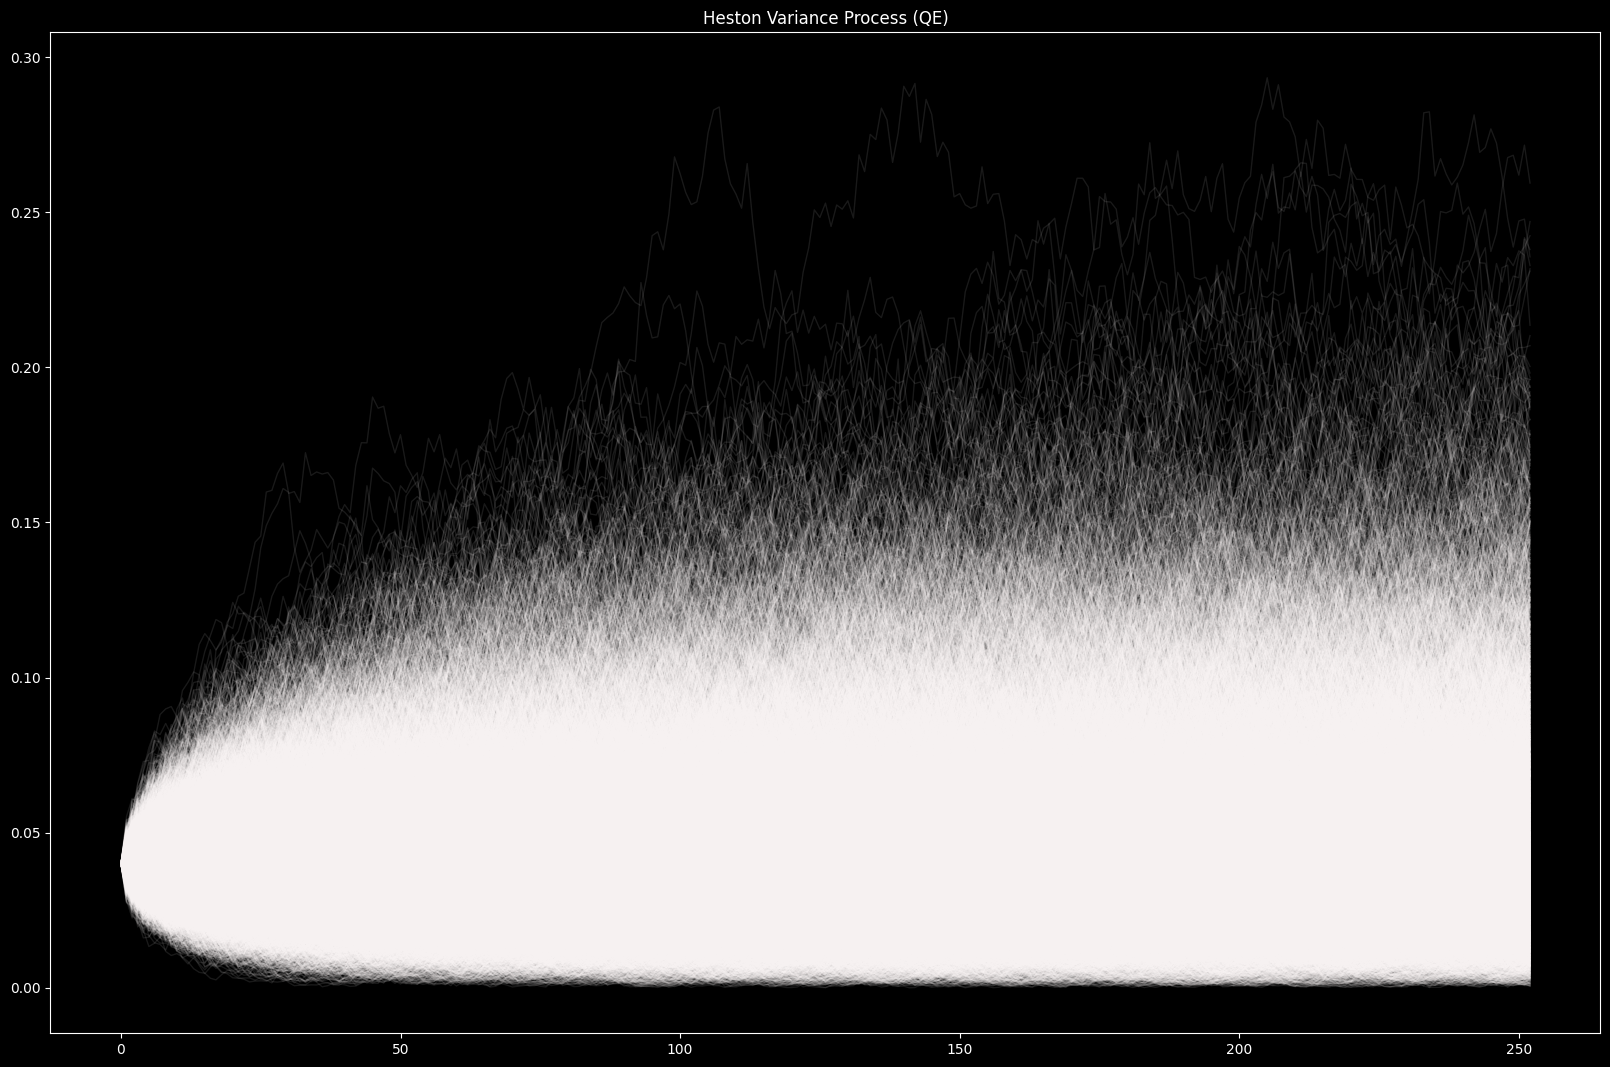

In [16]:
plt.figure(figsize=(20,13))

for v in V[::10]:
    plt.plot(v, color = "snow", lw = 1, alpha= 0.1)
plt.title("Heston Variance Process (QE)")
plt.show()

## Dupire

In [17]:
def make_inputs():
    s = [80, 90, 100, 110, 120]
    t = [0.2, 0.4, 0.8, 1.0]
    v = [
# S = 80    90    100   110   120    t =  
    [0.32, 0.26, 0.22, 0.25, 0.30],  # 0.2
    [0.30, 0.25, 0.21, 0.24, 0.28],  # 0.4
    [0.28, 0.24, 0.20, 0.23, 0.26],  # 0.8
    [0.26, 0.23, 0.19, 0.22, 0.25],  # 1.0
    ]
    return t, s, v

In [18]:
surface = LocalVolatilitySurface(*make_inputs())
surface.sigma(0.3, 85) #interpolation ex

0.28250000000000003

In [19]:
dupire = Dupire(r = 0.04, 
                q = 0.01, 
                local_volatility_surface=surface)
euler_dupire = EulerDupire(dupire)

In [20]:
npath = 10_000

mc = MonteCarlo(euler_dupire)


In [21]:
sim = mc.generate(100, 252, 1, npath)

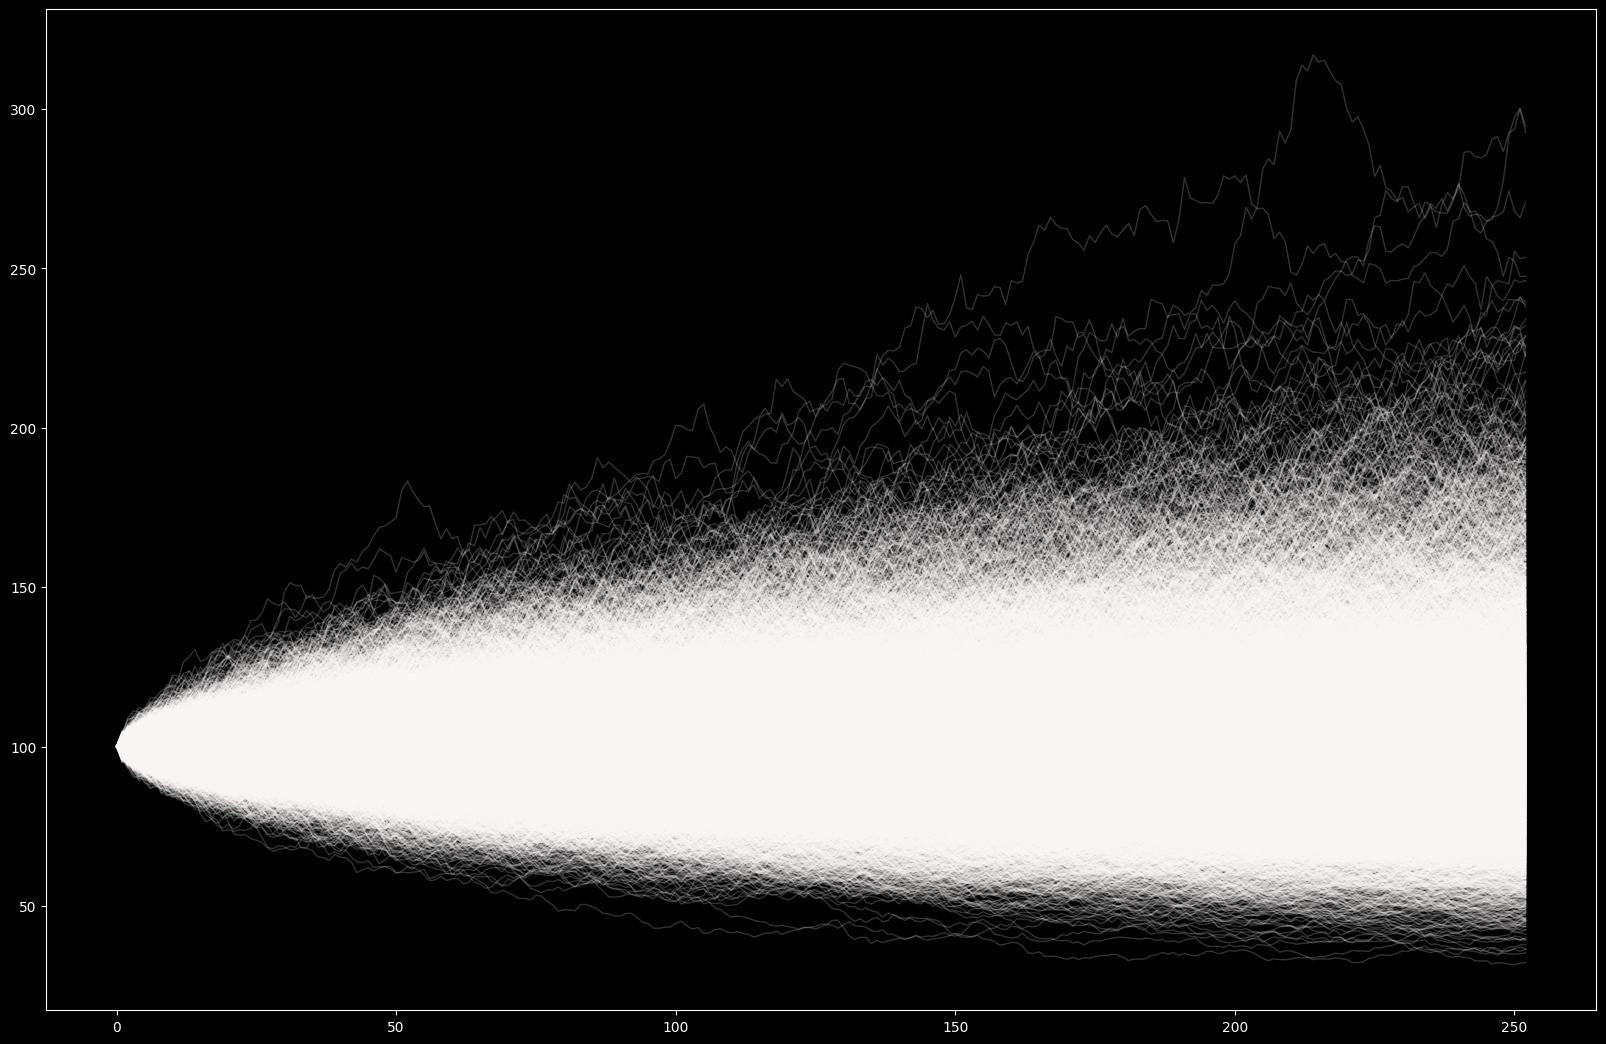

In [22]:
S = sim.spot_values()
plt.figure(figsize=(20,13))

for p in range(npath):
    plt.plot(S[p], lw = 1, color = "snow", alpha = 0.2)
plt.show()

## Pricing

In [3]:
from volmc import Instrument, OptionContract, CallPayoff, PutPayoff, DigitalCallPayoff, DigitalPutPayoff

In [12]:
from scipy.stats import norm
def bs_call_price(S, K, sigma, T, r):
    d1 = (np.log(S/K) + ((sigma**2)/2 + r)*T)/(sigma*np.sqrt(T))
    d2 = d1 - np.sqrt(T)*sigma

    return S* norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [18]:
strike = 105
T = 0.8
r = 0.02
S0 = 100
sigma = 0.15

contract = OptionContract(K = strike, T = T)
payoff_call = CallPayoff(strike)

call_option = Instrument(contract, payoff_call)

In [35]:
bs = BlackScholes(mu = r, sigma = sigma)
mc = MonteCarlo(EulerBlackScholes(bs))
mc.configure(seed=1, n_jobs=-1)

sim = mc.generate(S0 = S0, n = 252, T = T, n_paths = 100_000)

In [36]:
mc_payoff = call_option.compute_payoff(sim)
mc_price = mc_payoff*np.exp(-r*T)

In [37]:
print(f"Monte Carlo estimated price : {mc_price:.4f}")
print(f"Black-Scholes price : {bs_call_price(S0, strike, sigma, T, r):.4f}")

Monte Carlo estimated price : 3.9279
Black-Scholes price : 3.9322
